# Silvis WUI Class Analysis

Author: **Bryce A Young** | 
Created: **2025-01-31** | 
Modified: **2025-01-31**

In this notebook, we analyze the distribution of buildings in Ouray County among land classes according to the Silvis Global WUI raster. 

#### Data 
- (vector) Microsoft Building Footprints
- (raster) SILVIS Global WUI raster

#### Workflow 
- Import data
- Append WUI class to building footprint rows in the dataframe
- Save as csv
- Use pandas and matplotlib to visulaize distribution of buildings by WUI class
    - Building count by class
    - Percent of buildings by class
- Relate this to Caggiano et al. 2020 which reports on structure loss by WUI class in a short writeup at the bottom of the document
---
## Step 0: Setup Environment

In [5]:
import os
# Change directory
os.chdir('D:/_PROJECTS/P001_OurayParcel/ouray')

import geopandas as gpd
import pandas as pd
from utils.raster import read_raster

# Define frequently used paths
ws = 'D:/_PROJECTS/P001_OurayParcel'
data = os.path.join(ws, 'data')
geoms = os.path.join(data, 'county_geoms')
silvis_wui = os.path.join(data, 'silvis_wui')
scratch = os.path.join(data, '_temp')

# Import data
mbf = gpd.read_file(os.path.join(geoms, "buildings_WKID26913.gpkg"))                                     # Microsoft Building Footprints 2020
wui, transform = read_raster(os.path.join(silvis_wui, "wui_WKID26913.tif"), layer=1, transform=True)     # Silvis WUI

# Define crs
crs = mbf.crs

---
## Step 1: Perform Intersect Analysis

In [6]:
import geopandas as gpd
import rasterio as rio
import numpy as np

# Get building centroids (for point sampling)
mbf["centroid"] = mbf.geometry.centroid
# Convert centroids to raster row/col indices
rows, cols = rio.transform.rowcol(transform, mbf["centroid"].x, mbf["centroid"].y)
# Extract WUI values at those locations
mbf["wui_class"] = wui[rows, cols]

# Preview
mbf.head()


,County,geometry,centroid,wui_class
0,Ouray County,"POLYGON ((233065.026 4241048.982, 233062.078 4...",POINT (233065.909 4241052.6),5
1,Ouray County,"POLYGON ((242798.651 4243539.785, 242797.815 4...",POINT (242785.257 4243534.402),5
2,Ouray County,"POLYGON ((251220.802 4245432.876, 251222.012 4...",POINT (251212.196 4245423.292),1
3,Ouray County,"POLYGON ((244092.681 4241434.941, 244102.094 4...",POINT (244097.801 4241432.894),5
4,Ouray County,"POLYGON ((254080.659 4242775.668, 254082.582 4...",POINT (254078.896 4242776.879),5


In [16]:
# Create separate centroid and polygon files with wui class
mbf1 = mbf.drop(columns=['geometry'])
mbf2 = mbf.drop(columns=['centroid'])

# Save to scratch for later
mbf1.to_file(os.path.join(scratch, 'mbf_centroid_wui_class.gpkg'), driver='GPKG', index=False)
mbf2.to_file(os.path.join(scratch, 'mbf_poly_wui_class.gpkg'), driver='GPKG', index=False)

---
## Step 3: Create and Analyze Dataframe

In [9]:
import pandas as pd

classes = [0,1,2,3,4,5,6,7,8]

# Group by wui class
df = mbf.groupby("wui_class").size().to_frame(name="building_count").reset_index()
# Ensure all classes exist, filling missing ones with 0
df = df.set_index("wui_class").reindex(classes, fill_value=0).reset_index()

df

,wui_class,building_count
0,0,4
1,1,1801
2,2,616
3,3,979
4,4,0
5,5,724
6,6,408
7,7,0
8,8,1


In [10]:
bldg_total = df['building_count'].sum()

df['bldg_proportion'] = (df["building_count"] / bldg_total).round(5)

df

,wui_class,building_count,bldg_proportion
0,0,4,0.00088
1,1,1801,0.39731
2,2,616,0.13589
3,3,979,0.21597
4,4,0,0.00000
5,5,724,0.15972
6,6,408,0.09001
7,7,0,0.00000
8,8,1,0.00022


In [11]:
labels = ['Water',
          'Intermix WUI: Forest/Shrub/Wetl-dominated',
          'Interface WUI: Forest/Shrubland/Wetland-dominated',
          'Intermix WUI: Grassland-dominated',
          'Interface WUI: Grassland -dominated',
          'Non-WUI: Forest/Shrub/Wetland-dominated',
          'Non-WUI: Grassland-dominated',
          'Non-WUI: Urban',
          'Non-WUI: Other'
          ]

df['wui_label'] = labels

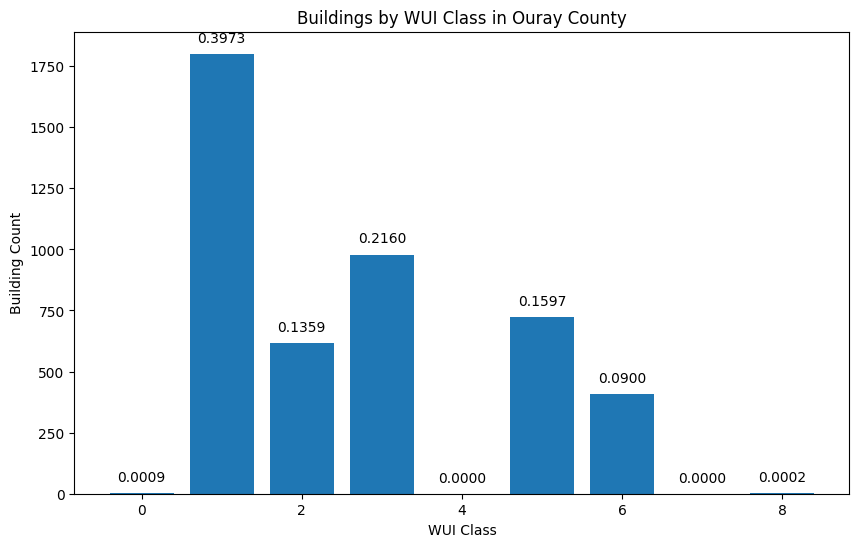

In [13]:
import matplotlib.pyplot as plt

# Plot 
x = df['wui_class']
y = df['building_count']
proportions = df['bldg_proportion']

# Initiate figure
plt.figure(figsize=(10, 6))
bars = plt.bar(x, y)

# Labels
plt.xlabel("WUI Class")
plt.ylabel("Building Count")
plt.title("Buildings by WUI Class in Ouray County")

for bar, prop in zip(bars, proportions):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + max(y) * 0.02,
             f'{prop:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.show()

In [14]:
df.to_csv(os.path.join(ws, 'output/tabular/bldg_by_wui_class.csv'), index=False)